In [61]:
# Ontwikkeld door Ahmad Al Dibo
# Ontwikkelde datum: 2025/08/09 augustus
# Versie: 1.0

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.model_selection import train_test_split
import tqdm
import numpy as np
import random
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense # type: ignore
from tensorflow.keras.models import Model # type: ignore
import matplotlib.pyplot as plt


In [37]:
directions = ["boven", "beneden", "links", "rechts"]
directions2Engels = {"boven": "up", "beneden": "down", "links": "left", "rechts": "right"}
word2int = {"up": 0, "down": 1, "left": 2, "right": 3}
int2word = {v: k for k, v in word2int.items()}

actions = ["ga", "loop", "beweeg", "draai", "verplaats je"]

aantallen = ["één", "twee", "drie", "vier", "vijf"]
aantal2int = {"één": 1, "twee": 2, "drie": 3, "vier": 4, "vijf": 5}

sen_length = 100

In [ ]:

glove_6b = lambda dim: f"data\\glove.6B\\glove.6B.{dim}d.txt"

### Laad Data of Data Maken

In [38]:
def load_data_with_steps(directions, directions2Engels, actions, aantallen, aantal2int):
    dataset = []
    labels_dir = []
    labels_steps = []

    for _ in tqdm.tqdm(range(15000), "Creating Random Data with Steps"): 
        action = random.choice(actions)
        aantal = random.choice(aantallen)
        direction = random.choice(directions)
        sentence = f"{action} {aantal} stappen naar {direction}"
        labels_dir.append(directions2Engels[direction])
        labels_steps.append(aantal2int[aantal])
        dataset.append(sentence)
    
    return dataset, labels_dir, labels_steps

X, Y_dir, Y_steps = load_data_with_steps(directions, directions2Engels, actions, aantallen, aantal2int)


Creating Random Data with Steps: 100%|██████████| 15000/15000 [00:00<00:00, 307804.19it/s]


In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=sen_length)

In [40]:
# --- Labels omzetten ---
Y_dir_int = [word2int[y] for y in Y_dir]
Y_dir_onehot = to_categorical(Y_dir_int, num_classes=4)

# aantal stappen van 1-5 => 0-4 indexeren voor one-hot
Y_steps_int = [y-1 for y in Y_steps]
Y_steps_onehot = to_categorical(Y_steps_int, num_classes=5)

In [41]:
Xtrain, Xtest, Ytrain_dir, Ytest_dir, Ytrain_steps, Ytest_steps = train_test_split(
    X_pad, Y_dir_onehot, Y_steps_onehot, test_size=0.3, random_state=7)

print("Train shape:", Xtrain.shape, Ytrain_dir.shape, Ytrain_steps.shape)
print("Test shape:", Xtest.shape, Ytest_dir.shape, Ytest_steps.shape)

Train shape: (10500, 100) (10500, 4) (10500, 5)
Test shape: (4500, 100) (4500, 4) (4500, 5)


In [ ]:
def generate_embedding(tokenizer, dim):
    embedding = {}
    # Pas pad aan naar jouw locatie van glove bestand
    with open(glove_6b(100), encoding="utf-8") as file:
        for line in tqdm.tqdm(file, "Reading the GloVe file"):
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:], dtype="float32")
            embedding[word] = vector
    
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    
    for word, i in word_index.items():
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    
    return embedding_matrix

embedding_matrix = generate_embedding(tokenizer, 100)

Reading the GloVe file: 400000it [00:19, 20120.71it/s]


In [ ]:
# def build_one_output_model(embedding_matrix, lstm_units, sen_length):
#     model = Sequential()
#     model.add(Input(shape=(sen_length,)))  
#     model.add(Embedding(input_dim=embedding_matrix.shape[0], 
#                         output_dim=embedding_matrix.shape[1], 
#                         weights=[embedding_matrix], 
#                         trainable=False))
#     model.add(LSTM(lstm_units, recurrent_dropout=0.2))
#     model.add(Dropout(0.3))
#     model.add(Dense(4, activation="softmax"))
#     model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])
#     model.summary()
#     return model

#model = build_one_output_model(embedding_matrix, 128, 100)

def build_multi_output_model(embedding_matrix, lstm_units, sen_length):
    input_layer = Input(shape=(sen_length,))
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                weights=[embedding_matrix],
                                trainable=False)(input_layer)
    lstm_layer = LSTM(lstm_units, recurrent_dropout=0.2)(embedding_layer)
    dropout_layer = Dropout(0.3)(lstm_layer)

    output_direction = Dense(4, activation="softmax", name="direction_output")(dropout_layer)
    output_steps = Dense(5, activation="softmax", name="steps_output")(dropout_layer)

    model = Model(inputs=input_layer, outputs=[output_direction, output_steps])
    model.compile(
        optimizer="rmsprop",
        loss={
            "direction_output": "categorical_crossentropy",
            "steps_output": "categorical_crossentropy"
        },
        metrics={
            "direction_output": "accuracy",
            "steps_output": "accuracy"
        }
    )
    model.summary()
    return model

model = build_multi_output_model(embedding_matrix, 128, sen_length)

Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │      1,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    117,248 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction_output    │ (None, 4)         │        516 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steps_output        │ (None, 5)         │        645 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,209 (469.57 KB)

 Trainable params: 118,409 (462.54 KB)

 Non-trainable params: 1,800 (7.03 KB)

### Build LSTM model:

In [46]:
history = model.fit(Xtrain,
                    {"direction_output": Ytrain_dir, "steps_output": Ytrain_steps},
                    validation_data=(Xtest, {"direction_output": Ytest_dir, "steps_output": Ytest_steps}),
                    batch_size=64,
                    epochs=10)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - direction_output_accuracy: 0.9921 - direction_output_loss: 0.1227 - loss: 0.6129 - steps_output_accuracy: 0.7612 - steps_output_loss: 0.4898 - val_direction_output_accuracy: 1.0000 - val_direction_output_loss: 0.0014 - val_loss: 0.2810 - val_steps_output_accuracy: 0.8051 - val_steps_output_loss: 0.2811
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - direction_output_accuracy: 1.0000 - direction_output_loss: 0.0013 - loss: 0.2965 - steps_output_accuracy: 0.7904 - steps_output_loss: 0.2946 - val_direction_output_accuracy: 1.0000 - val_direction_output_loss: 3.6166e-04 - val_loss: 0.2802 - val_steps_output_accuracy: 0.8000 - val_steps_output_loss: 0.2818
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - direction_output_accuracy: 1.0000 - direction_output_loss: 6.1492e-04 - loss: 0.2895 - steps_output_accuracy: 0.8033 - steps_output_loss: 0.2878 - val_direction_output_accuracy: 1.0000 - val_direction_output_loss: 1.8

In [47]:
model.save("multi_output_model.h5")

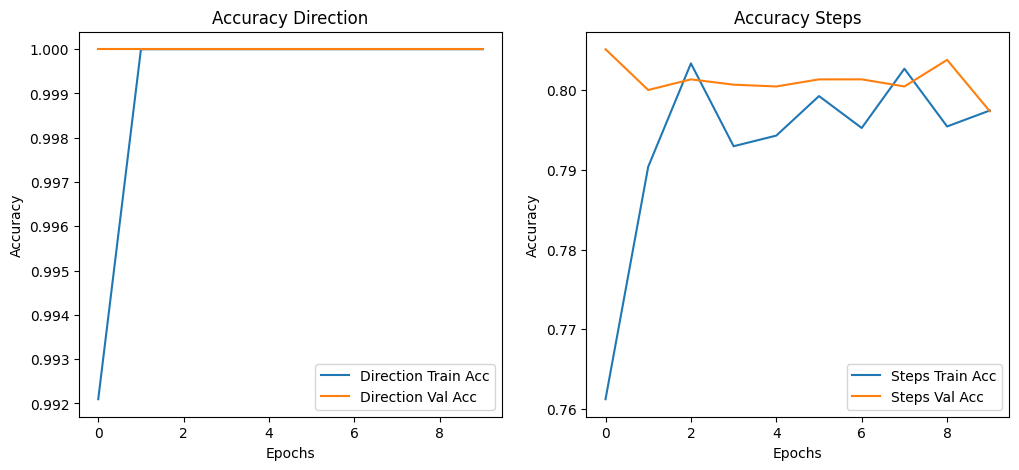

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['direction_output_accuracy'], label='Direction Train Acc')
plt.plot(history.history['val_direction_output_accuracy'], label='Direction Val Acc')
plt.title('Accuracy Direction')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['steps_output_accuracy'], label='Steps Train Acc')
plt.plot(history.history['val_steps_output_accuracy'], label='Steps Val Acc')
plt.title('Accuracy Steps')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
def prediction_multi(model, sms, tokenizer):
    seq = tokenizer.texts_to_sequences([sms])
    seq = pad_sequences(seq, maxlen=sen_length)
    pred_dir, pred_steps = model.predict(seq)
    pred_dir_index = np.argmax(pred_dir, axis=1)[0]
    pred_steps_index = np.argmax(pred_steps, axis=1)[0]

    direction = int2word[pred_dir_index]
    steps = pred_steps_index + 1  # omdat index 0 = 1 stap

    return direction, steps

In [51]:
import json


report = history.history
report.keys()
with open("training_history_mulit_model_output.json", "w") as f:
    json.dump(history.history, f)

import pickle
with open('tokenizer_mulit_output_model.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_sentence = "ga vier stappen naar beneden"
direction_pred, steps_pred = prediction_multi(model, test_sentence, tokenizer)
print(f"Voorspelling: richting = {direction_pred}, stappen = {steps_pred}")
# er kan een fout optreden als je (vijf) gebruikt!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Voorspelling: richting = down, stappen = 4
